# Model mismatched entity prediction analysis
In this notebook, we'll dig deeper into why the SciERC model was able to outperform all other models on PICKLE.

The script `evaluate_model_output.py` contains an option, `--save_mismatches`, which is used to generate the output used in this notebook. Evaluation is performed without consoideration of types, but types are included in the output to facilitate downstream analysis of model performance based on type categories.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 14})
import jsonlines
from ast import literal_eval
from collections import defaultdict, Counter
from functools import reduce

## Reading in the mismatches

In [2]:
all_models = pd.read_csv('../data/straying_off_topic_data/model_output/mismatch_analysis/all_on_pickle_08Aug2023_with_mismatches_MISMATCHES.csv')
all_models_filtered = pd.read_csv('../data/straying_off_topic_data/model_output/dygiepp/15Jul2023_all_on_pickle_but_seedev/performance/all_models_on_filtered_genia_11Aug2023_with_cells_MISMATCHES.csv')

In [3]:
all_models["model_shorthand"] = all_models["model"].str.split('_').str[-2]
all_models.head()

,doc_key,mismatch_type,sent_num,gold_ent_list,gold_ent_type,pred_ent_list,pred_ent_type,model,model_shorthand
0,PMID10549554_abstract,1,0,"[1, 2, 'Biochemical_pathway']",Biochemical_pathway,"[1, 2, 'Biochemical_pathway', 7.2228, 0.9938]",Biochemical_pathway,/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-c...,pickle
1,PMID10549554_abstract,1,0,"[4, 5, 'Multicellular_organism']",Multicellular_organism,"[4, 5, 'Multicellular_organism', 7.7682, 0.9995]",Multicellular_organism,/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-c...,pickle
2,PMID10549554_abstract,1,0,"[7, 9, 'Biochemical_process']",Biochemical_process,"[7, 9, 'Biochemical_process', 6.9548, 0.9949]",Biochemical_process,/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-c...,pickle
3,PMID10549554_abstract,1,0,"[11, 11, 'Biochemical_process']",Biochemical_process,"[11, 11, 'Biochemical_pathway', 0.6049, 0.6082]",Biochemical_pathway,/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-c...,pickle
4,PMID10549554_abstract,1,0,"[14, 16, 'Virus']",Virus,"[14, 16, 'Virus', 3.3194, 0.5612]",Virus,/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-c...,pickle


In [4]:
all_models_filtered["model_shorthand"] = all_models_filtered["model"].str.split('_').str[-2]
all_models_filtered.head()

,doc_key,mismatch_type,sent_num,gold_ent_list,gold_ent_type,pred_ent_list,pred_ent_type,model,model_shorthand
0,PMID10549554_abstract,2,0,NaN,NaN,"[1, 2, 'biochemical_pathway', 7.2228, 0.9938]",biochemical_pathway,/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-c...,pickle
1,PMID10549554_abstract,2,0,NaN,NaN,"[4, 5, 'multicellular_organism', 7.7682, 0.9995]",multicellular_organism,/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-c...,pickle
2,PMID10549554_abstract,2,0,NaN,NaN,"[7, 9, 'biochemical_process', 6.9548, 0.9949]",biochemical_process,/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-c...,pickle
3,PMID10549554_abstract,2,0,NaN,NaN,"[11, 11, 'biochemical_pathway', 0.6049, 0.6082]",biochemical_pathway,/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-c...,pickle
4,PMID10549554_abstract,2,0,NaN,NaN,"[14, 16, 'virus', 3.3194, 0.5612]",virus,/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-c...,pickle


Let's separate the predictions by model:

In [5]:
per_model = {} 
for model in all_models['model_shorthand'].unique():
    df = all_models[all_models['model_shorthand']==model]
    per_model[model] = df
per_model_filtered = {} 
for model in all_models_filtered['model_shorthand'].unique():
    df = all_models_filtered[all_models_filtered['model_shorthand']==model]
    per_model_filtered[model] = df

## Recall by category
To get an idea of in which categories the model performs well versus poorly, we can take a look at the recall broken down by category. The formula for recall is:

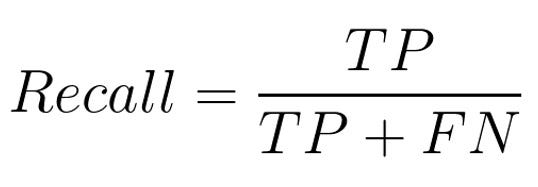

For each type, we have true positives (`mismatch_type` is 1), false negatives (`mismatch_type` is 0), and false positives (`mismatch_type` is 2), so we can calculate these values per type. The types for true and false positives are the predicted types (which is the same as the gold standard type for true positives), and the types for false negatives are the gold standard type.

The main question we're looking to answer with this analysis is why all models but GENIA perform more poorly on the GENIA-filtered PICKLE test set than on the full test set. Our hypothesis is that the other models have a more even spread of performance across all types, and that filtering down the test set only benefits GENIA since that was the metric by which we performed the filtering.

In [6]:
def calc_recall_per_type(mismatches):
    """
    Recall is the number of instances with mismatch_type == 1, divided by the sum of instances
    where the mismatch type == 1 and mismatch_type == 0, for all instances of a given gold_ent_type

    parameters:
        mismatches, df: mismatches df for a given model

    returns:
        recall, dict: recall values per type
    """
    grouped = mismatches.groupby(by=['gold_ent_type', 'mismatch_type']).count()
    recall = {}
    for gold_type in grouped.index.get_level_values('gold_ent_type'):
        try:
            tp = grouped.loc[(gold_type, 1), 'gold_ent_list']
        except KeyError:
            tp = 0
        try:
            fn = grouped.loc[(gold_type, 0), 'gold_ent_list']
        except KeyError:
            fn = 0
        rec_type = tp / (tp + fn)
        recall[gold_type] = rec_type
    
    return recall

In [7]:
rec_full_dset = {}
for model, dset in per_model.items():
    recall = calc_recall_per_type(dset)
    rec_full_dset[model] = recall
rec_filtered_dset = {}
for model, dset in per_model_filtered.items():
    recall = calc_recall_per_type(dset)
    rec_filtered_dset[model] = recall

In [8]:
all_models_filtered['gold_ent_type'].dropna().unique()

array(['dna', 'cell_type', 'protein', 'rna'], dtype=object)

In [9]:
our_models = {'scierc':0, 'genia':1, 'chemprot':2, 'seedev':3, 'pickle':4}
model_map = {
    'scierc': 'SciERC',
    'genia': 'GENIA',
    'chemprot': 'ChemProt',
    'seedev': 'SeeDev',
    'pickle': 'PICKLE'
}
full_type_map = {typ:' '.join(typ.split('_')) for typ in all_models['gold_ent_type'].dropna().unique()}
filtered_type_map = {typ:' '.join(typ.split('_')).capitalize() for typ in all_models_filtered['gold_ent_type'].dropna().unique()}
filtered_type_map['dna'] = 'DNA'
filtered_type_map['rna'] = 'RNA'

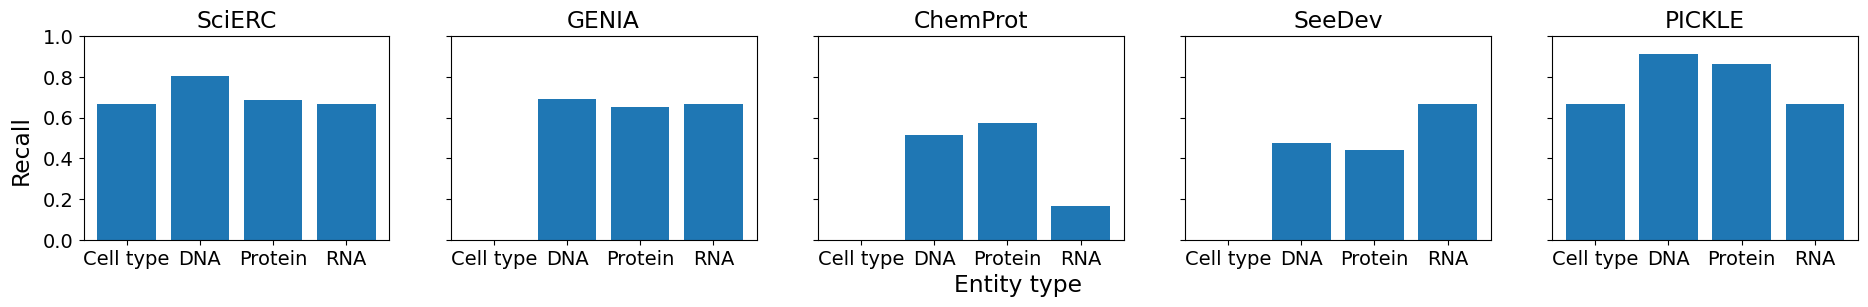

In [10]:
fig, axs = plt.subplots(1,5, figsize=(21, 3), sharey=True, sharex=True)

for mod, col in our_models.items():
    axs[col].bar(range(len(rec_filtered_dset[mod])), list(rec_filtered_dset[mod].values()), tick_label=list(rec_filtered_dset[mod].keys()))
    axs[col].set_title(model_map[mod])
    axs[col].set_ylim(0, 1)
    semantic_xlabs = [filtered_type_map[lab] for lab in [t.get_text() for t in axs[col].get_xticklabels()]]
    axs[col].set_xticklabels(semantic_xlabs)
fig.supylabel('Recall')
fig.supxlabel('Entity type')
plt.subplots_adjust(left=0.055, bottom=0.2)
plt.savefig('../data/straying_off_topic_data/model_performance/filtered_type_recall.png', format='png', bbox_inches='tight', dpi=600)

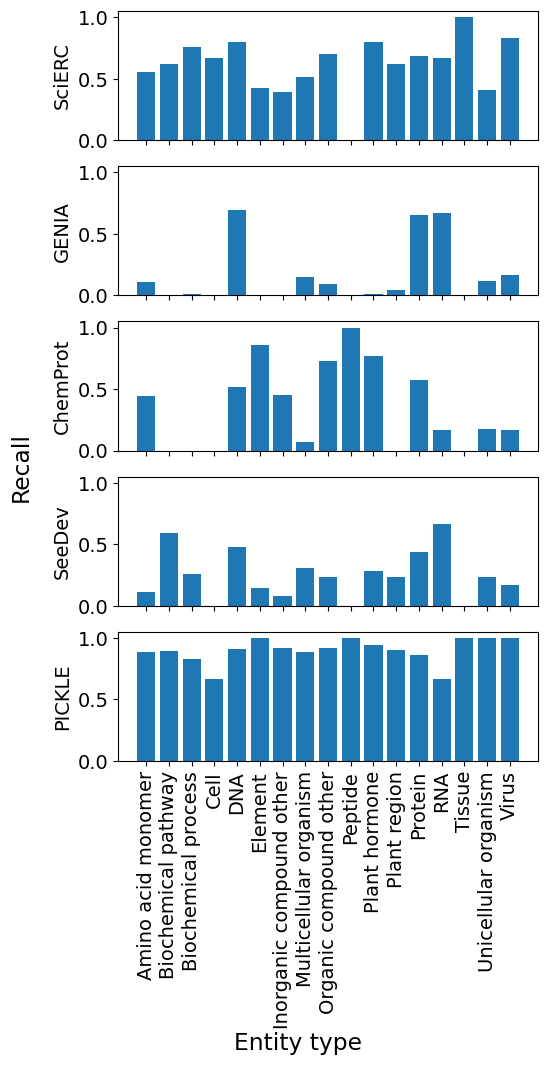

In [11]:
fig, axs = plt.subplots(5,1, figsize=(6,12), sharey=True, sharex=True)

for mod, row in our_models.items():
    axs[row].bar(range(len(rec_full_dset[mod])), list(rec_full_dset[mod].values()), tick_label=list(rec_full_dset[mod].keys()))
    axs[row].set_ylabel(model_map[mod])
semantic_xlabs = [full_type_map[lab] for lab in [t.get_text() for t in axs[4].get_xticklabels()]]
axs[4].set_xticklabels(semantic_xlabs, rotation=90)
fig.supylabel('Recall')
fig.supxlabel('Entity type')
plt.subplots_adjust(left=0.2, bottom=0.255)
plt.savefig('../data/straying_off_topic_data/model_performance/all_type_recall.png', format='png', bbox_inches='tight', dpi=600)

## Proportions of predictions made on each type
To get deeper into the precision of each model, we can visualize how many of the model's predictions were made for each type. High precision can be obtained two ways: Make a large number of predictions across all categories, and often be right (high precision and high recall), or make a small number of predictions focused ona few categories, and often be right (high precision and low recall). We want to visualize the proportion of a model's predictions that were made in each category to make sure these are holding true for our models; we expect GENIA to have a large proportion of predictions dedicated to a few categories, and the other models to have a more even spread.

Because the models all predict different types, we need to only look at true positives to get an idea of what types form the gold standard are being captured. We can't look at false positives, because there's no way to tie them  back to the categories in the gold standard for the models that predict types from a different original dataset.

We want to know the proportion of the original predictions that correspond to the types remaining in the filtered analysis; therefore, we only need to look at the results from before filtering.

In [48]:
props_full = defaultdict(dict)
gold_types = all_models[all_models['model_shorthand'] == 'pickle']['gold_ent_type'].dropna().unique().tolist()
for model, dset in per_model.items():
    total_true_preds = len(dset[dset['mismatch_type'] == 1])
    for ent_type in gold_types:
        this_type_true_preds = dset[(dset['mismatch_type'] == 1) & (dset['gold_ent_type'] == ent_type)]
        this_ent_prop = len(this_type_true_preds)/total_true_preds
        props_full[model][ent_type] = this_ent_prop

In [93]:
in_filtered = {
    'dna': 'DNA',
    'cell_type': 'Cell',
    'protein': 'Protein',
    'rna': 'RNA'
}
amalgamated_props = defaultdict(dict)
for model, props in props_full.items():
    in_filt_prop = 0
    out_filt_prop = 0
    for ent_type, prop in props.items():
        if ent_type in in_filtered.values():
            in_filt_prop += prop
        else:
            out_filt_prop += prop
    amalgamated_props[model]['in_filtered'] = in_filt_prop
    amalgamated_props[model]['out_filtered'] = out_filt_prop

In [74]:
colors = {
    'Biochemical_pathway': '#1F77B4',
 'Multicellular_organism': '#AEC7E8',
 'Biochemical_process': '#FF7F0E',
 'Virus': '#FFBB78',
 'Organic_compound_other': '#2CA02C',
 'Plant_hormone': '#98DF8A',
 'DNA': '#D62728',
 'Cell': '#FF9896',
 'Protein': '#9467BD',
 'Plant_region': '#C5B0D5',
 'Inorganic_compound_other': '#8C564B',
 'Amino_acid_monomer': '#C49C94',
 'RNA': '#E377C2',
 'Tissue': '#F7B6D2',
 'Peptide': '#7F7F7F',
 'Unicellular_organism': '#C7C7C7',
 'Element': '#BCBD22'
}

In [79]:
orig_label_key = {'chemprot': 'ChemProt',
         'scierc': 'SciERC',
         'bioinfer': 'BioInfer',
         'genia': 'GENIA',
         'pickle': 'PICKLE',
         'scierc-lightweight': 'SciERC\nLightweight',
         'genia-lightweight': 'GENIA\nLightweight',
         'ace05-relation': 'ACE05',
         'seedev': 'SeeDev'}

<BarContainer object of 8 artists>

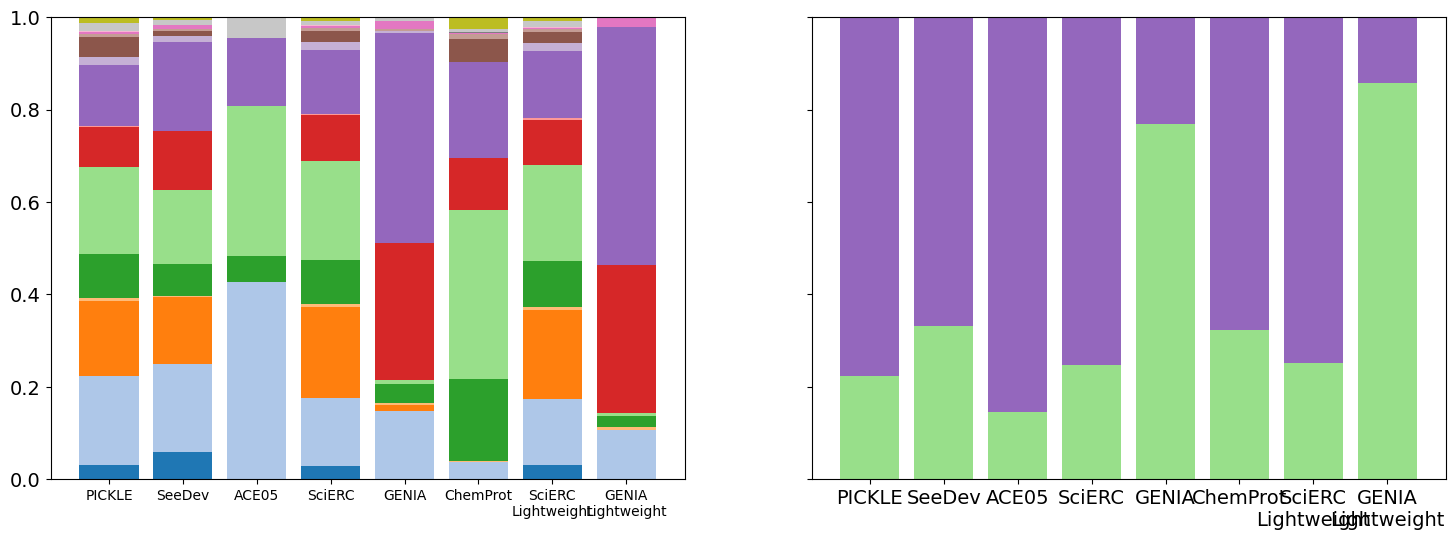

In [99]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(18,6))
prev_vals = {mod: 0 for mod in props_full.keys()}
for i, ent in enumerate(gold_types):
    color = colors[ent]
    this_ent_x = []
    this_ent_props = []
    for mod, props in props_full.items():
        this_ent_props.append(props[ent])
        this_ent_x.append(mod)
    axs[0].bar(this_ent_x, this_ent_props, bottom=list(prev_vals.values()), color=color)
    current_vals = {i: j for i, j in zip(this_ent_x, this_ent_props)}
    prev_vals = {k: prev_vals[k] + v for k, v in current_vals.items()}
fig.canvas.draw()
name_x = [orig_label_key[mod.get_text()] for mod in axs[0].get_xticklabels()]
orig_x = [mod.get_text() for mod in axs[0].get_xticklabels()]
axs[0].set_xticks(orig_x, name_x, size=10, ha='center')

axs[1].bar(amalgamated_props.keys(), [amalgamated_props[mod]['in_filtered'] for mod in amalgamated_props.keys()], color='#98DF8A')
axs[1].bar(amalgamated_props.keys(), [amalgamated_props[mod]['out_filtered'] for mod in amalgamated_props.keys()], bottom=[amalgamated_props[mod]['in_filtered'] for mod in amalgamated_props.keys()], color='#9467BD')

I think the right plot shows what I'm trying to get at in a much clearer way, let's keep that one and finish formatting it!

In [108]:
amalg_df = pd.DataFrame.from_dict({'model': amalgamated_props.keys(),
                                  'in_filt': [amalgamated_props[mod]['in_filtered'] for mod in amalgamated_props.keys()],
                                  'out_filt': [amalgamated_props[mod]['out_filtered'] for mod in amalgamated_props.keys()]}).sort_values(by='in_filt')
amalg_df

,model,in_filt,out_filt
2,ace05-relation,0.146067,0.853933
0,pickle,0.223355,0.776645
3,scierc,0.246626,0.753374
6,scierc-lightweight,0.251572,0.748428
5,chemprot,0.323851,0.676149
1,seedev,0.330688,0.669312
4,genia,0.767932,0.232068
7,genia-lightweight,0.857143,0.142857


Text(0.5, 31.722222222222207, 'Model')

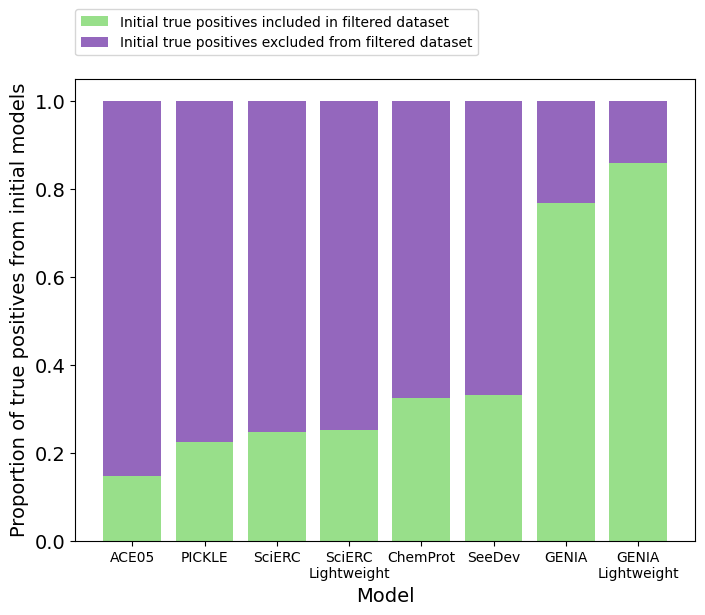

In [123]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.bar(amalg_df['model'], amalg_df['in_filt'], color='#98DF8A', label='Initial true positives included in filtered dataset')
ax.bar(amalg_df['model'], amalg_df['out_filt'], bottom=amalg_df['in_filt'], color='#9467BD', label='Initial true positives excluded from filtered dataset')
fig.canvas.draw()
name_x = [orig_label_key[mod.get_text()] for mod in ax.get_xticklabels()]
orig_x = [mod.get_text() for mod in ax.get_xticklabels()]
ax.set_xticks(orig_x, name_x, size=10, ha='center')
ax.legend(loc=(0,1.05), fontsize=10)
plt.ylabel('Proportion of true positives from initial models')
plt.xlabel('Model')

This appears to correspond with the difference in performance for both F1 and precision; let's make a figure to visually compare! We'll make a vertical set of subplots to be able to look at them all in the same order. I didn't include ACE05 in the initial anlysis here, so I will also remove it from the plot we just made.

In [ ]:
# Drop ACE05
amalg_df = amalg_df.drop(labels=[2], axis=0)

In [144]:
mean_diffs = pd.read_csv('../data/straying_off_topic_data/model_performance/diff_mean_F1_prec_by_model.csv')
mean_diffs

,x,model,f1_mean_diff,precision_mean_diff,recall_mean_diff
0,0,genia-lightweight,-0.293250,0.078596,-0.448109
1,1,genia,-0.228417,0.128133,-0.461419
2,2,seedev,0.147143,0.249579,-0.136856
3,3,chemprot,0.181057,0.399896,-0.155323
4,4,scierc-lightweight,0.347034,0.358137,-0.068738
5,5,scierc,0.357665,0.361248,-0.051801
6,6,pickle,0.567863,0.687252,0.019227


We want to represent these as how much worse the models got after filtering, so we need to flip the signs before plotting:

In [145]:
mean_diffs['f1_mean_diff'] = mean_diffs['f1_mean_diff'] * -1
mean_diffs['precision_mean_diff'] = mean_diffs['precision_mean_diff'] * -1
mean_diffs['recall_mean_diff'] = mean_diffs['recall_mean_diff'] * -1
mean_diffs

,x,model,f1_mean_diff,precision_mean_diff,recall_mean_diff
0,0,genia-lightweight,0.293250,-0.078596,0.448109
1,1,genia,0.228417,-0.128133,0.461419
2,2,seedev,-0.147143,-0.249579,0.136856
3,3,chemprot,-0.181057,-0.399896,0.155323
4,4,scierc-lightweight,-0.347034,-0.358137,0.068738
5,5,scierc,-0.357665,-0.361248,0.051801
6,6,pickle,-0.567863,-0.687252,-0.019227


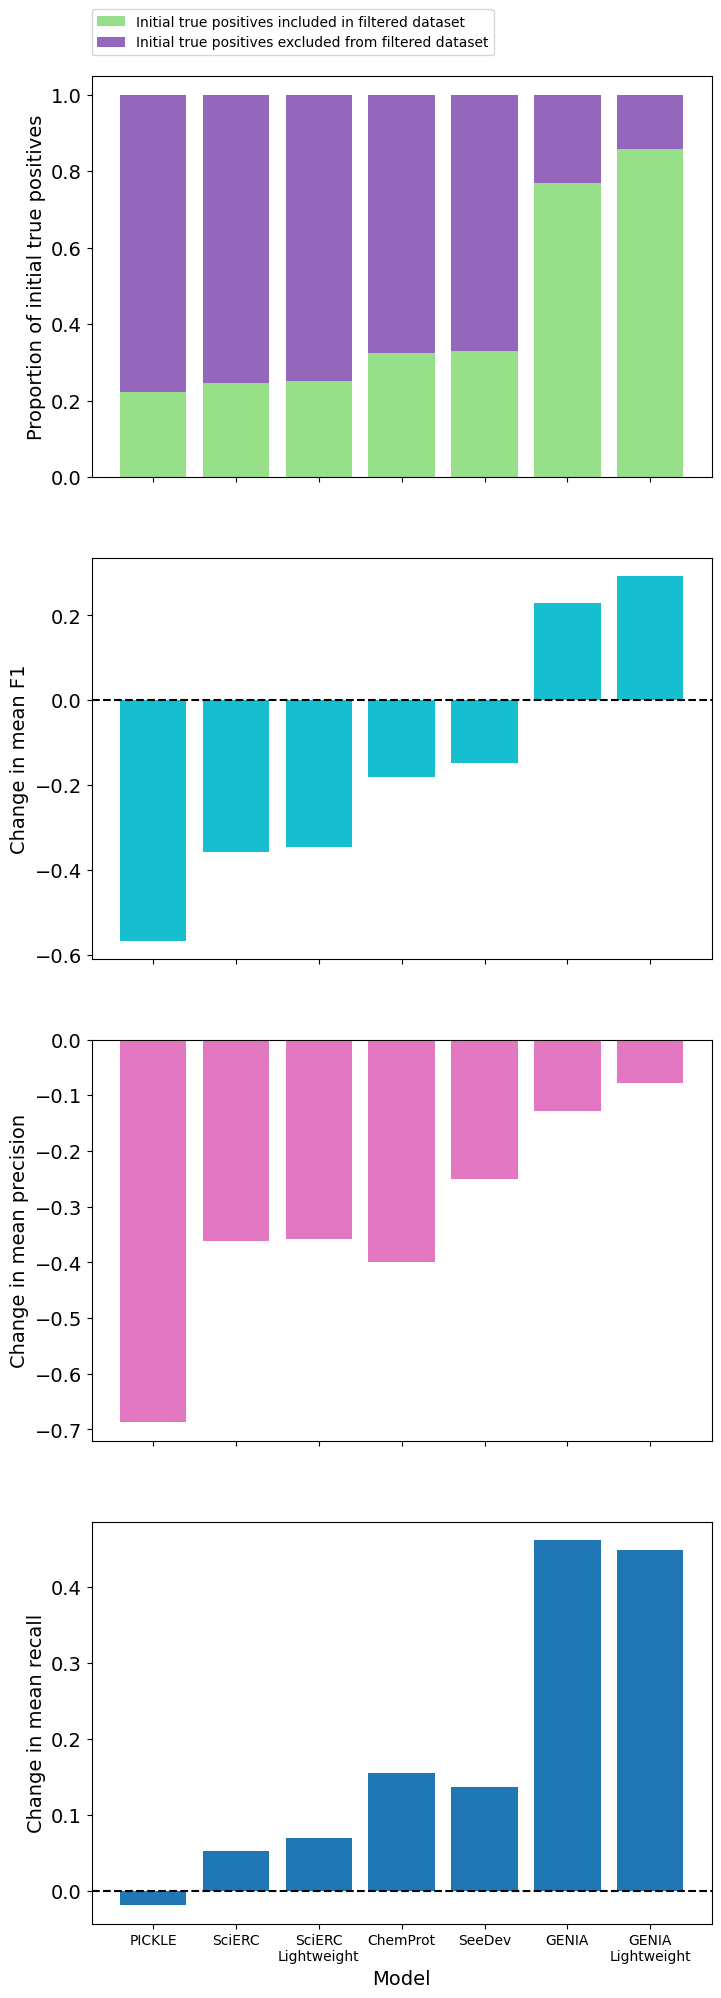

In [159]:
fig, axs = plt.subplots(4, 1, figsize=(8,24), sharex=True)

# Proportions
axs[0].bar(amalg_df['model'], amalg_df['in_filt'], color='#98DF8A', label='Initial true positives included in filtered dataset')
axs[0].bar(amalg_df['model'], amalg_df['out_filt'], bottom=amalg_df['in_filt'], color='#9467BD', label='Initial true positives excluded from filtered dataset')
axs[0].set_ylabel('Proportion of initial true positives')

# F1 changes
axs[1].bar(mean_diffs['model'], mean_diffs['f1_mean_diff'], color='#17BECF')
axs[1].axhline(0, color='black', linestyle='--')
axs[1].set_ylabel('Change in mean F1')

# Precision changes
axs[2].bar(mean_diffs['model'], mean_diffs['precision_mean_diff'], color='#E377C2')
axs[2].set_ylabel('Change in mean precision')

# Recall changes
axs[3].bar(mean_diffs['model'], mean_diffs['recall_mean_diff'], color='#1F77B4')
axs[3].axhline(0, color='black', linestyle='--')
axs[3].set_ylabel('Change in mean recall')

# Final aesthetics
fig.canvas.draw()
name_x = [orig_label_key[mod.get_text()] for mod in axs[3].get_xticklabels()]
orig_x = [mod.get_text() for mod in axs[3].get_xticklabels()]
axs[3].set_xticks(orig_x, name_x, size=10, ha='center')
axs[0].legend(loc=(0,1.05), fontsize=10)
axs[3].set_xlabel('Model')

plt.savefig('../data/straying_off_topic_data/model_performance/delta_perf_with_type_props.png', format='png', bbox_inches='tight', dpi=600)

## False positive analysis
Just looking at recall per type doesn't explain why all models but GENIA perform more poorly when the dataset is filtered. The next hypothesis is that the filterind results in a greater proportion of false positives for all models but GENIA; we'll test that here by comparing the proportion of all predictions that are false positives before and after filtering.

In [14]:
prop_fp = {'Model': [], 'On original PICKLE test set': [], 'On GENIA-filtered PICKLE test set': []}
for model, dset in per_model.items():
    if model in ['seedev', 'scierc', 'genia', 'chemprot', 'pickle']:
        fp_all = len(dset[dset['mismatch_type'] == 2])
        fp_filt = len(per_model_filtered[model][per_model_filtered[model]['mismatch_type'] == 2])
        tot_preds = len(dset['pred_ent_list'].dropna().unique())
        prop_fp['Model'].append(model)
        prop_fp['On original PICKLE test set'].append(fp_all/tot_preds)
        prop_fp['On GENIA-filtered PICKLE test set'].append(fp_filt/tot_preds)
prop_fp_df = pd.DataFrame(prop_fp)
prop_fp_df['Model'] = prop_fp_df['Model'].map(model_map)  
sorter = lambda column: column.map({mod: order for order, mod in enumerate(['GENIA', 'SeeDev', 'ChemProt', 'SciERC', 'PICKLE'])})
prop_fp_df = prop_fp_df.sort_values('Model', key=sorter)
prop_fp_df = prop_fp_df.set_index('Model')
prop_fp_df

,On original PICKLE test set,On GENIA-filtered PICKLE test set
Model,,
GENIA,0.444965,0.573770
SeeDev,0.628319,0.877089
ChemProt,0.412596,0.809769
SciERC,0.520588,0.881765
PICKLE,0.116298,0.802621


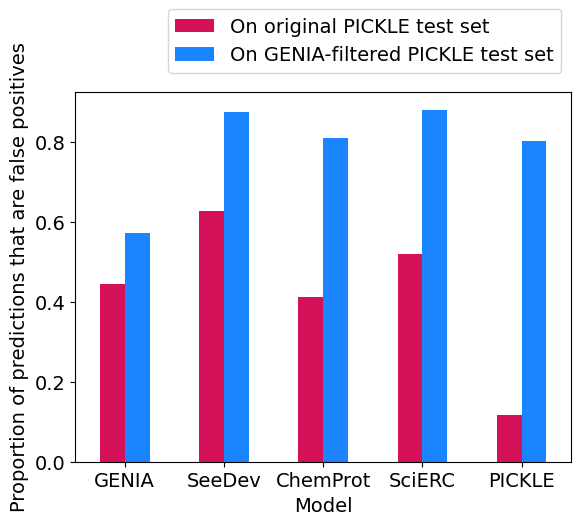

In [15]:
ax = prop_fp_df.plot.bar(color={
    'On original PICKLE test set': '#D41159',
    'On GENIA-filtered PICKLE test set': '#1A85FF'
}, ylabel='Proportion of predictions that are false positives', rot=0)
ax.legend(bbox_to_anchor=(1.0, 1.25))
plt.savefig('../data/straying_off_topic_data/model_performance/false_pos_comparison.png', format='png', bbox_inches='tight', dpi=600)

This goes a long way to explaining what we observe, but not all the way. For example, we see that GENIA indeed has the lowest proportion of false positives on the filtered dataset, which we expect. We also see that PICKLE has the greatest change om false positive proportion, which corresponds to the large decrease in performance we see on the filtered dataset. However, we would expect the performance reduction to be proportional to the increase in false positives for all models, so we would expect that SeeDev and ChemProt should have the next-smallest increase in false positive proportion, and SciERC should have the next-largest. However, false positives are only one part of the precision metric, which is likely what's driving the change. Let's take a look at both precision and recall for the models on both the filtered and full datasets.

## Overall precision and recall

In [173]:
orig_perf_seedev = pd.read_csv('../data/straying_off_topic_data/model_output/dygiepp/15Jul2023_all_on_pickle_but_seedev/performance/17Jul2023_seedev_on_pickle_performance_no_labels.csv')
orig_perf_all = pd.read_csv('../data/straying_off_topic_data/model_output/dygiepp/15Jul2023_all_on_pickle_but_seedev/performance/15Jul2023_all_on_pickle_no_seedev_performance.csv')
orig_perf_all = pd.concat([orig_perf_seedev, orig_perf_all])
orig_perf_all['model'] = orig_perf_all['pred_file'].str.split('_').str[-2]
orig_perf_all = orig_perf_all.reset_index(drop=True).sort_values('ent_F1').reset_index(drop=True)
orig_perf_all

,pred_file,gold_std_file,ent_precision,ent_recall,ent_F1,rel_precision,rel_recall,rel_F1,ent_precision_CI,ent_recall_CI,ent_F1_CI,rel_precision_CI,rel_recall_CI,rel_F1_CI,model
0,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.193694,0.072919,0.105819,0.000000,0.000000,0.000000,"(0.1429979253112033, 0.2502936241610738)","(0.05333745205549978, 0.09474637681159417)","(0.07839296166227686, 0.13527554548482587)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)",ace05-relation
1,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.570708,0.160570,0.249894,NaN,NaN,NaN,"(0.49902699456975774, 0.643936419763142)","(0.11667512308468143, 0.20724809293513485)","(0.19321837835989722, 0.3061844812816278)",NaN,NaN,NaN,genia-lightweight
2,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.557187,0.196518,0.289868,NaN,NaN,NaN,"(0.4912152530292231, 0.6242472804972805)","(0.1523317471518495, 0.24312158926383784)","(0.23576190476190473, 0.3419524854981555)",NaN,NaN,NaN,genia
3,17Jul2023_seedev_on_pickle_PICKLE_250_abstract...,PICKLE_250_abstracts_entities_and_relations_FI...,0.373344,0.314438,0.340887,0.167352,0.066984,0.094928,"(0.31789976918733104, 0.4304071630210769)","(0.26929228179228176, 0.35934436835687483)","(0.29586052643654476, 0.3803187764879307)","(0.04750056420672534, 0.349972186904005)","(0.017564797672573393, 0.14164540816326524)","(0.0264594334393325, 0.19697090527267153)",seedev
4,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.589271,0.377282,0.459691,0.118089,0.023735,0.039048,"(0.5134214210792485, 0.6597671470822966)","(0.31619556173564173, 0.4429260106656407)","(0.3932587830568571, 0.5283259376302464)","(0.04967592592592593, 0.20930232558139536)","(0.007501830573391912, 0.04328817733990146)","(0.013247961852022767, 0.06758396923631556)",chemprot
5,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.478597,0.656190,0.553169,0.072374,0.089572,0.079652,"(0.4294379741252424, 0.5316811214758135)","(0.6164612612449871, 0.691908914545175)","(0.5141514693449252, 0.5977567158569393)","(0.03612494415231811, 0.11568160175684078)","(0.04887108610567514, 0.13172888094778185)","(0.042886436544521116, 0.1180061037639878)",scierc-lightweight
6,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.478968,0.674144,0.559745,0.057466,0.086344,0.068621,"(0.43032869912059807, 0.5308687868236084)","(0.6406513153003568, 0.7108491030638333)","(0.5190181925003347, 0.6002697495183045)","(0.03457632090684005, 0.08541554231822657)","(0.057188308886971524, 0.12067924528301884)","(0.044473370023383384, 0.09702656546489562)",scierc
7,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.883557,0.891106,0.887275,0.608037,0.348510,0.442015,"(0.857079027355623, 0.9084136564951275)","(0.8753625636815292, 0.9081251757571311)","(0.8689741295964972, 0.9057122261710511)","(0.5372982621414583, 0.685561797752809)","(0.27739304532720793, 0.41112138949349963)","(0.37580711361156444, 0.49925964546402507)",pickle


In [174]:
# All models without types
all_models_on_filtered_without_types = pd.read_csv('..//data/straying_off_topic_data/model_output/dygiepp/15Jul2023_all_on_pickle_but_seedev/performance/all_models_on_filtered_genia_11Aug2023_with_cells_bootstrapped.csv')
all_models_on_filtered_without_types['model'] = all_models_on_filtered_without_types['pred_file'].str.split('_').str[-2]
all_models_on_filtered_without_types = all_models_on_filtered_without_types.reset_index(drop=True)
all_models_on_filtered_without_types

,pred_file,gold_std_file,ent_precision,ent_recall,ent_F1,rel_precision,rel_recall,rel_F1,ent_precision_CI,ent_recall_CI,ent_F1_CI,rel_precision_CI,rel_recall_CI,rel_F1_CI,model
0,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.196304,0.871879,0.319412,0.608308,0.349621,0.443126,"(0.1396223282657809, 0.2536349845067998)","(0.8302206137309293, 0.905416090563429)","(0.24048643111265616, 0.3950951078594647)","(0.5351891592920355, 0.6845060137457044)","(0.29213198524815603, 0.4070155197059424)","(0.3803468129229426, 0.4958700093172913)",pickle
1,17Jul2023_seedev_on_pickle_PICKLE_250_abstract...,PICKLE_250_abstracts_entities_and_relations_FI...,0.123765,0.451294,0.193744,0.172778,0.070205,0.099143,"(0.08427548478918341, 0.16452058359356636)","(0.37478466365562174, 0.5235430567795543)","(0.13886920291265917, 0.2466113003878252)","(0.05120160213618158, 0.36581325981832147)","(0.01981980670703307, 0.1475890521723086)","(0.027745980707395503, 0.2048551154595982)",seedev
2,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.027433,0.045780,0.034097,0.000000,0.000000,0.000000,"(0.004227158948685857, 0.061717752234993616)","(0.007630135387488329, 0.10102599755614536)","(0.005494505494505494, 0.07540977521985237)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)",ace05-relation
3,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.117721,0.725945,0.202080,0.057325,0.086451,0.068530,"(0.08372011392389075, 0.15248650400910316)","(0.6629472140762463, 0.7906734557036292)","(0.14940574959387326, 0.2533201691383651)","(0.03159895599650712, 0.0871151589021307)","(0.053178662769455605, 0.12210031347962376)","(0.041185130502664355, 0.09749345316213781)",scierc
4,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.429054,0.657937,0.518286,NaN,NaN,NaN,"(0.337121662168154, 0.5116045101292872)","(0.593459706232632, 0.7142857142857143)","(0.4347237960339943, 0.5841851482252541)",NaN,NaN,NaN,genia
5,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.189375,0.532605,0.278634,0.117245,0.023807,0.039058,"(0.13447278897640375, 0.24404261482705059)","(0.4528256158759124, 0.6231186440677966)","(0.20777827755569905, 0.34428871268656713)","(0.0361280487804878, 0.2222222222222222)","(0.005711066109223935, 0.04477057998980556)","(0.009906542056074767, 0.06996537146013469)",chemprot
6,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.120460,0.724928,0.206135,0.072730,0.089974,0.080001,"(0.08537838833926525, 0.15801008146776485)","(0.6536473795001889, 0.7901773313492063)","(0.1506853696921359, 0.2609709866636982)","(0.03895708463198274, 0.11528441850653917)","(0.05349740152142803, 0.13150194531503295)","(0.044762787919202025, 0.12254183363202507)",scierc-lightweight
7,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.492113,0.608679,0.543144,NaN,NaN,NaN,"(0.3949423956232654, 0.5804834148884966)","(0.5424804882929758, 0.6684288537549407)","(0.4641350805876706, 0.6073907982509812)",NaN,NaN,NaN,genia-lightweight


In [175]:
sorter = lambda column: column.map({mod: order for order, mod in enumerate(orig_perf_all.model)})
all_models_on_filtered_without_types = all_models_on_filtered_without_types.sort_values('model', key=sorter).reset_index(drop=True)
all_models_on_filtered_without_types

,pred_file,gold_std_file,ent_precision,ent_recall,ent_F1,rel_precision,rel_recall,rel_F1,ent_precision_CI,ent_recall_CI,ent_F1_CI,rel_precision_CI,rel_recall_CI,rel_F1_CI,model
0,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.027433,0.045780,0.034097,0.000000,0.000000,0.000000,"(0.004227158948685857, 0.061717752234993616)","(0.007630135387488329, 0.10102599755614536)","(0.005494505494505494, 0.07540977521985237)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)",ace05-relation
1,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.492113,0.608679,0.543144,NaN,NaN,NaN,"(0.3949423956232654, 0.5804834148884966)","(0.5424804882929758, 0.6684288537549407)","(0.4641350805876706, 0.6073907982509812)",NaN,NaN,NaN,genia-lightweight
2,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.429054,0.657937,0.518286,NaN,NaN,NaN,"(0.337121662168154, 0.5116045101292872)","(0.593459706232632, 0.7142857142857143)","(0.4347237960339943, 0.5841851482252541)",NaN,NaN,NaN,genia
3,17Jul2023_seedev_on_pickle_PICKLE_250_abstract...,PICKLE_250_abstracts_entities_and_relations_FI...,0.123765,0.451294,0.193744,0.172778,0.070205,0.099143,"(0.08427548478918341, 0.16452058359356636)","(0.37478466365562174, 0.5235430567795543)","(0.13886920291265917, 0.2466113003878252)","(0.05120160213618158, 0.36581325981832147)","(0.01981980670703307, 0.1475890521723086)","(0.027745980707395503, 0.2048551154595982)",seedev
4,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.189375,0.532605,0.278634,0.117245,0.023807,0.039058,"(0.13447278897640375, 0.24404261482705059)","(0.4528256158759124, 0.6231186440677966)","(0.20777827755569905, 0.34428871268656713)","(0.0361280487804878, 0.2222222222222222)","(0.005711066109223935, 0.04477057998980556)","(0.009906542056074767, 0.06996537146013469)",chemprot
5,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.120460,0.724928,0.206135,0.072730,0.089974,0.080001,"(0.08537838833926525, 0.15801008146776485)","(0.6536473795001889, 0.7901773313492063)","(0.1506853696921359, 0.2609709866636982)","(0.03895708463198274, 0.11528441850653917)","(0.05349740152142803, 0.13150194531503295)","(0.044762787919202025, 0.12254183363202507)",scierc-lightweight
6,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.117721,0.725945,0.202080,0.057325,0.086451,0.068530,"(0.08372011392389075, 0.15248650400910316)","(0.6629472140762463, 0.7906734557036292)","(0.14940574959387326, 0.2533201691383651)","(0.03159895599650712, 0.0871151589021307)","(0.053178662769455605, 0.12210031347962376)","(0.041185130502664355, 0.09749345316213781)",scierc
7,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.196304,0.871879,0.319412,0.608308,0.349621,0.443126,"(0.1396223282657809, 0.2536349845067998)","(0.8302206137309293, 0.905416090563429)","(0.24048643111265616, 0.3950951078594647)","(0.5351891592920355, 0.6845060137457044)","(0.29213198524815603, 0.4070155197059424)","(0.3803468129229426, 0.4958700093172913)",pickle


In [176]:
def process_ent_only_CIs(df, kind='F1'):
    """
    literal_evals the CI strings in a given df, and returns two sets of CIs,
    one for entities and one for relations.
    """
    ent_CIs = df[f"ent_{kind}_CI"].apply(lambda x: literal_eval(str(x)))
    ent_CIs = pd.DataFrame([[df[f'ent_{kind}'][i] - val[0] for i, val in enumerate(ent_CIs)], [val[1] - df[f'ent_{kind}'][i] for i, val in enumerate(ent_CIs)]])

    return ent_CIs

In [177]:
all_no_filter_ent_CIs_precision = process_ent_only_CIs(orig_perf_all, kind='precision')
filter_ent_CIs_precision = process_ent_only_CIs(all_models_on_filtered_without_types, kind='precision')
all_no_filter_ent_CIs_recall = process_ent_only_CIs(orig_perf_all, kind='recall')
filter_ent_CIs_recall = process_ent_only_CIs(all_models_on_filtered_without_types, kind='recall')

In [179]:
all_no_filter_ent_CIs_precision = all_no_filter_ent_CIs_precision.drop(columns=[0])
filter_ent_CIs_precision = filter_ent_CIs_precision.drop(columns=[0])
all_no_filter_ent_CIs_recall = all_no_filter_ent_CIs_recall.drop(columns=[0])
filter_ent_CIs_recall = filter_ent_CIs_recall.drop(columns=[0])

In [180]:
x_dict = {mod:i for i,mod in enumerate(orig_perf_all["model"].values.tolist())}
orig_perf_all["x"] = orig_perf_all["model"].map(x_dict)
all_models_on_filtered_without_types["x"] = all_models_on_filtered_without_types["model"].map(x_dict)

In [181]:
orig_perf_all = orig_perf_all.drop(labels=[0], axis=0).reset_index(drop=True)
all_models_on_filtered_without_types = all_models_on_filtered_without_types.drop(labels=[0], axis=0).reset_index(drop=True)

In [182]:
orig_label_key = {'chemprot': 'ChemProt',
         'scierc': 'SciERC',
         'bioinfer': 'BioInfer',
         'genia': 'GENIA',
         'pickle': 'PICKLE',
         'scierc-lightweight': 'SciERC\nLightweight',
         'genia-lightweight': 'GENIA\nLightweight',
         #'ace05-relation': 'ACE05',
         'seedev': 'SeeDev'}

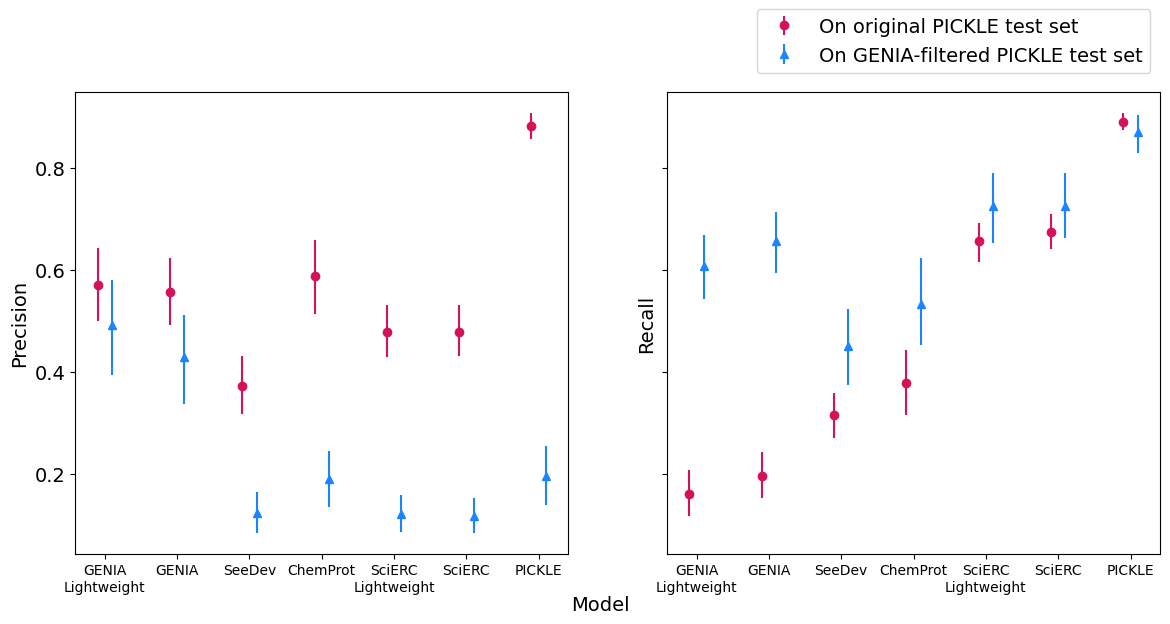

In [183]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True, sharex=True)

name_x = [orig_label_key[mod] for mod in orig_perf_all["model"]]

axs[0].errorbar(x=orig_perf_all['x'] - 0.1, y=orig_perf_all['ent_precision'], yerr=all_no_filter_ent_CIs_precision, fmt='o', color='#D41159', label='On original PICKLE test set')
axs[0].errorbar(x=all_models_on_filtered_without_types['x'] + 0.1, y=all_models_on_filtered_without_types['ent_precision'], yerr=filter_ent_CIs_precision, fmt='^', color='#1A85FF', label='On GENIA-filtered PICKLE test set')

axs[0].set_xticks(all_models_on_filtered_without_types['x'], name_x, size=10, ha='center')
axs[0].set_ylabel('Precision')


axs[1].errorbar(x=orig_perf_all['x'] - 0.1, y=orig_perf_all['ent_recall'], yerr=all_no_filter_ent_CIs_recall, fmt='o', color='#D41159', label='On original PICKLE test set')
axs[1].errorbar(x=all_models_on_filtered_without_types['x'] + 0.1, y=all_models_on_filtered_without_types['ent_recall'], yerr=filter_ent_CIs_recall, fmt='^', color='#1A85FF', label='On GENIA-filtered PICKLE test set')

axs[1].set_xticks(all_models_on_filtered_without_types['x'], name_x, size=10, ha='center')
axs[1].set_ylabel('Recall')

axs[1].legend(bbox_to_anchor=(1, 1.2))

fig.supxlabel('Model', size=14)

plt.savefig('../data/straying_off_topic_data/model_performance/filtered_vs_not_precision_and_recall_F1.png', format='png', bbox_inches='tight', dpi=600)

This completes our picture! We can see that the overall recall for SeeDev and ChemProt substantially increase on the filtered dataset, as opposed to SciERC and PICKLE, which, when combined with the patterns in the change of precision, explain why the ChemProt and SeeDev model have smaller F1 performance decreases on the filtered dataset than SciERC.